## Get started with Multi-product formulas (MPFs)

This guide demonstrates how to use the `qiskit-addon-mpf` package, using the time evolution of an Ising model as an example. With this package, you can build a Multi-Product Formula (MPF) that can achieve lower Trotter error on observable measurements. The tools provided allow you to determine the weights of a chosen MPF, which can then be used to recombine the estimated expectation values from several time evolution circuits, each with a different number of Trotter steps.

Begin by considering the Hamiltonian of an Ising model with 10 sites:

$$ H_{\text{Ising}} = \sum_{i=1}^9 J_{i,(i+1)}Z_iZ_{i+1} + \sum_{i=1}^{10} h_i X_i $$

where $J_{i,(i+1)}$ is the coupling strength and $h_i$ is an external magnetic field strength. To set up the problem, the observable to measure will be the total magnetization of the system

$$ \langle M \rangle = \sum_{i=1}^{10} \langle Z_i \rangle. $$

The code snippet below prepares the Hamiltonian of the Ising chain using the `qiskit-addon-utils` package, and defines the observable that will be measured.

In [1]:
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_addon_utils.problem_generators import (
    generate_xyz_hamiltonian,
    generate_time_evolution_circuit,
)
from qiskit_addon_mpf.costs import (
    setup_exact_problem,
    setup_sum_of_squares_problem,
)
from qiskit_addon_mpf.static import setup_static_lse

from scipy.linalg import expm
import numpy as np

# Generate some coupling map to use for this example
coupling_map = CouplingMap.from_line(10, bidirectional=False)

# Get a qubit operator describing the Ising field model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)
print(f"Hamiltonian:\n {hamiltonian}\n")

L = coupling_map.size()
observable = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1 / L / 2) for i in range(L)], num_qubits=L
)
print(f"Observable:\n {observable}")

Hamiltonian:
 SparsePauliOp(['IIIIIIIZZI', 'IIIIIZZIII', 'IIIZZIIIII', 'IZZIIIIIII', 'IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j,
 0.4+0.j, 0.4+0.j, 0.4+0.j])

Observable:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j])


Next you prepare the MPF. The first choice to make is whether the coefficients will be static (time-independent) or dynamic; this tutorial uses a static MPF. The next choice to make is the set of $k_j$ values. This determines how many terms will be in the MPF, as well as how many Trotter steps each term uses to simulate the time evolution. The choice of $k_j$ values is heuristic, so you need to obtain your own set of "good" $k_j$ values. Read guidelines on finding a good set of values at the end of the [getting started page](/guides/qiskit-addons-mpf#determine-mpf-coefficients).

Then, once the $k_j$ values are determined, you can prepare the system of equations, $Ax=b$, to solve can be prepared. The matrix $A$ is also determined by the product formula to use. The choices here are its *order*, which is set to $2$ in this example, as well as whether or not the product formula should be *symmetric*, which is set to `True` for this example. The code snippet below selects a total time to evolve the system, the $k_j$ values to use, and the set of equations to solve using the [`qiskit_addon_mpf.static.setup_static_lse`](../api/qiskit-addon-mpf/static) method.

In [2]:
time = 8.0
trotter_steps = (8, 12, 19)

lse = setup_static_lse(trotter_steps, order=2, symmetric=True)
print(lse)

LSE(A=array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.56250000e-02, 6.94444444e-03, 2.77008310e-03],
       [2.44140625e-04, 4.82253086e-05, 7.67336039e-06]]), b=array([1., 0., 0.]))


Once the linear system of equations has been instantiated, it can be solved either exactly or through an approximate model using a sum of squares (or the Frobenius norm for dynamic coefficients; see the [API reference](../api/qiskit-addon-mpf/costs) for more information). The choice to use an approximate model typically arises when the norm of the coefficients for the chosen set of $k_j$ values is deemed too high and a different set of $k_j$ values cannot be chosen. This guide demonstrates both to compare the results.

In [3]:
model_exact, coeffs_exact = setup_exact_problem(lse)
model_approx, coeffs_approx = setup_sum_of_squares_problem(
    lse, max_l1_norm=3.0
)
model_exact.solve()
model_approx.solve()
print(f"Exact solution: {coeffs_exact.value}")
print(f"Approximate solution: {coeffs_approx.value}")

Exact solution: [ 0.17239057 -1.19447005  2.02207947]
Approximate solution: [-0.40454257  0.57553173  0.8290123 ]


<Admonition type="note">

The `LSE` object also possesses an `LSE.solve()` method, which will solve the system of equations exactly. The reason that `setup_exact_problem()` is used in this guide is to demonstrate the interface provided by the other approximate methods.

</Admonition>

## Set up and execute Trotter circuits

Now that the coefficients $x_j$ have been obtained, the last step is to generate the time evolution circuits for the order and chosen set of steps $k_j$ of the MPF. The `qiskit-addon-utils` package can accelerate this process.

In [4]:
circuits = []
for k in trotter_steps:
    circ = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(order=2, reps=k),
        time=time,
    )
    circuits.append(circ)

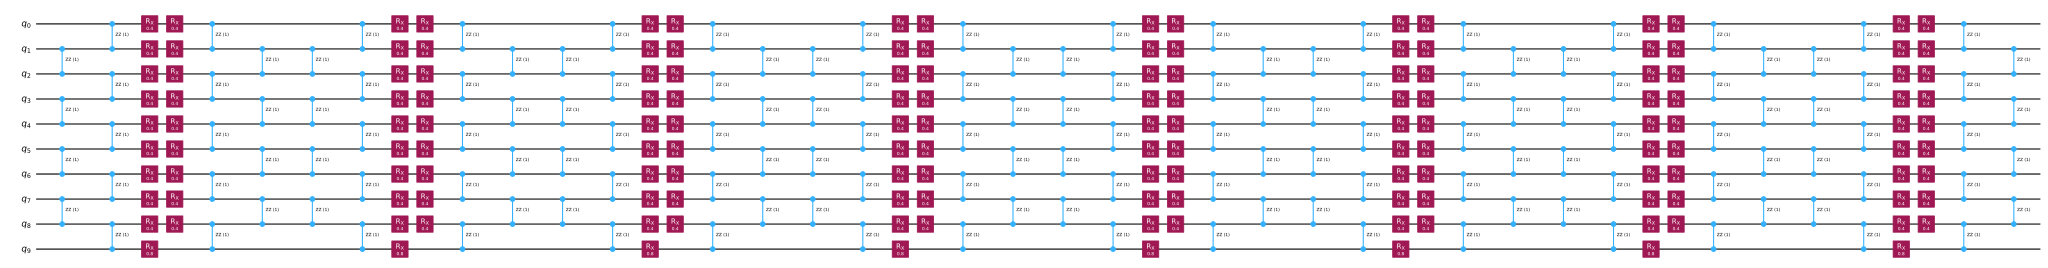

In [5]:
circuits[0].draw("mpl", fold=-1)

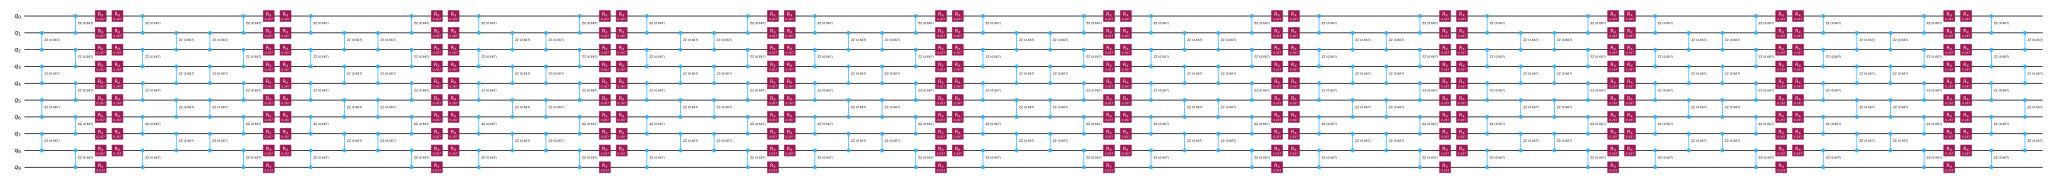

In [6]:
circuits[1].draw("mpl", fold=-1)

In [7]:
circuits[2].draw("mpl", fold=-1)

Once these circuits have been constructed, you can then transpile and execute them using a QPU. For this example, we'll just use one of the noise-free simulators to demonstrate how the Trotter error is reduced.

In [8]:
backend = GenericBackendV2(num_qubits=10)
transpiler = generate_preset_pass_manager(
    optimization_level=2, backend=backend
)

transpiled_circuits = [transpiler.run(circ) for circ in circuits]


estimator = StatevectorEstimator()
job = estimator.run([(circ, observable) for circ in transpiled_circuits])
result = job.result()

mpf_evs = [res.data.evs for res in result]
print(mpf_evs)

[array(0.23799162), array(0.35754312), array(0.38649906)]


## Reconstruct results

Now that the circuits have been executed, reconstructing the results is fairly straightforward. As mentioned in the [MPF overview](./qiskit-addons-mpf#theoretical-background) page, our observable is reconstructed through the weighted sum

$$ \langle M \rangle = \sum_j x_j \langle M_j \rangle. $$

where $x_j$ are the coefficients we found and $\langle M_j \rangle$ is the estimation of the observable $\sum_i \langle Z_i \rangle$ for each circuit. We can then compare the results we obtained with the exact value using the `scipy.linalg` package.

In [9]:
exp_H = expm(-1j * time * hamiltonian.to_matrix())
initial_state = np.zeros(exp_H.shape[0])
initial_state[0] = 1.0

time_evolved_state = exp_H @ initial_state
exact_obs = (
    time_evolved_state.conj() @ observable.to_matrix() @ time_evolved_state
)


# Print out the different observable measurements
print(f"Exact value: {exact_obs.real}")
print(f"PF with 19 steps: {mpf_evs[-1]}")
print(f"MPF using exact solution: {mpf_evs @ coeffs_exact.value}")
print(f"MPF using approximate solution: {mpf_evs @ coeffs_approx.value}")

Exact value: 0.4006024248789992
PF with 19 steps: 0.38649906199774786
MPF using exact solution: 0.39548478559800576
MPF using approximate solution: 0.4299121425349022


Here you can see that the MPF has reduced the Trotter error compared to the one obtained with just a single PF with $k_j=19$. However, the approximate model resulted in an expectation value that is worse than the exact model. This demonstrates the importance of using tight convergence criteria on the approximate model and finding a "good" set of $k_j$ values.